In [1]:
import PIL as pil
from matplotlib import pyplot as plt
import numpy as np
import math
from datetime import datetime
import cv2

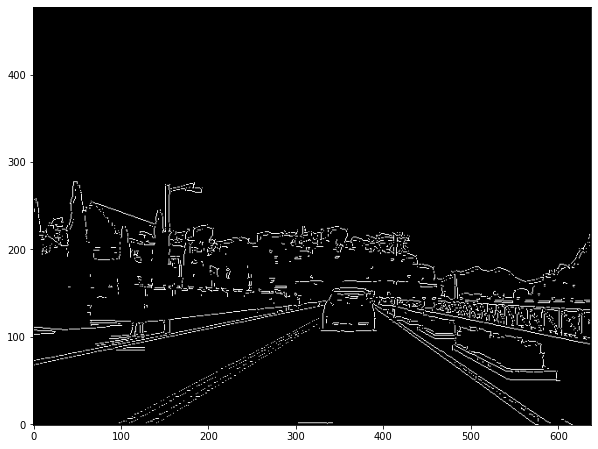

In [20]:
raw_input = np.fromfile("../Image/ldw_refoutput.bin", dtype='uint8', sep="")
ldw_input = raw_input[0:304964]
nR = 478
nC = 638
ldw_input = ldw_input.reshape([nR, nC])
myimg = np.zeros([nR, nC])


# Revert the picture upside down.
for i in range(nR):
    for j in range(nC):
        myimg[i,j] = ldw_input[nR-i-1,j]

mygrayimg = np.copy(myimg)
myhysteresis = np.copy(myimg)

# origin
f, axarr = plt.subplots(1,1, figsize=(10, 10))
axarr.imshow(mygrayimg, cmap='gray', origin='lower')

In [21]:
def hough_line(img, theta_res=1, rho_res=1, pfrac=0.1):
    x_max = img.shape[0]
    y_max = img.shape[1]
    
    theta_max = 1.0 * math.pi 
    theta_min = 0.0
    
    r_min = 0.0
    r_max = math.hypot(x_max, y_max)
    r_dim = 600 
    theta_dim = 800

    thetas = np.zeros((theta_dim,1))
    rhos = np.zeros((r_dim,1))
    hough_space = np.zeros((r_dim,theta_dim))

    for x in range(x_max):
        for y in range(y_max):
            if img[x,y]:
                for itheta in range(theta_dim):
                    theta = 1.0 * itheta * theta_max / theta_dim
                    r = x * math.cos(theta) + y * math.sin(theta)
                    ir = int(r_dim * ( 1.0 * r ) / r_max)
                    if ir >= 0 and ir < r_dim:
                        hough_space[ir,itheta] = hough_space[ir,itheta] + 1
  

    return hough_space, thetas, rhos

In [22]:
start_time = datetime.now()
myHoughimg, thetas, rhos = hough_line(myhysteresis, 0.6, 3.64, 0.1)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:08.297863


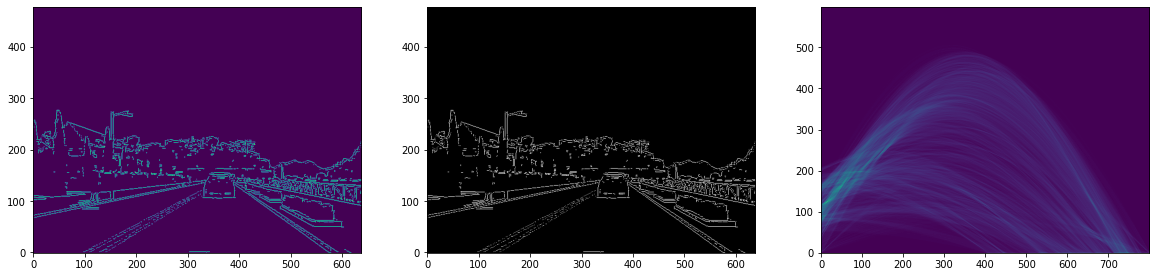

In [23]:
# Orig vs. Gray vs. Hough transform
f, axarr = plt.subplots(1,3, figsize=(20, 20))
axarr[0].imshow(myimg, origin='lower')
axarr[1].imshow(myhysteresis, cmap='gray', origin='lower')
axarr[2].imshow(myHoughimg, origin='lower')

In [40]:
import scipy.ndimage.filters as filters
import scipy.ndimage as ndimage

neighborhood_size = 5
threshold = 150

width, height = myhysteresis.shape
r_max = np.ceil(np.sqrt(width * width + height * height))   # max_dis
theta_max = np.pi
r_dim, theta_dim = myHoughimg.shape

x_max = width
y_max = height

# GxH, GyH, GH, thetaH = calculateGradient(myHoughimg)

epsilon = 0.000001
x, y = [], []

for i in range(r_dim):
    for j in range(theta_dim):
        if np.abs(myHoughimg[i,j]) > threshold:
            x.append(j)
            y.append(i)
            
# Filter zeros.
tmpx = np.copy(x)
tmpy = np.copy(y)
x, y = [], []
for i in range(len(tmpx)):
    if tmpx[i] > 0 and tmpy[i] > 0:
        x.append(tmpx[i])
        y.append(tmpy[i])
        
# Keep only the bigest in 
tmpx = np.copy(x)
tmpy = np.copy(y)
x, y = [], []

while len(tmpx)>0:
    
    maxval = myHoughimg[tmpy[0], tmpx[0]]
    current_maxx = tmpx[0]
    current_maxy = tmpy[0]
    
    for i in range(len(tmpx)):
        if myHoughimg[tmpy[i], tmpx[i]]> maxval:
            maxval = myHoughimg[tmpy[i], tmpx[i]]
            current_maxx = tmpx[i]
            current_maxy = tmpy[i]
    
    x.append(current_maxx)
    y.append(current_maxy)
            
    # Remove the biggest and local maximum nearby
    newx = []
    newy = []
    
    for i in range(len(tmpx)):
        if np.sqrt(np.abs(tmpx[i] - current_maxx)*np.abs(tmpx[i] - current_maxx) + np.abs(tmpy[i] - current_maxy)*np.abs(tmpy[i] - current_maxy)) > neighborhood_size:
            newx.append(tmpx[i])
            newy.append(tmpy[i])
            
    tmpx = newx
    tmpy = newy
    
    print("new len: ", len(newx))



print("x_len: ", len(x))
print("x: ", x)
print("y: ", y)


new len:  27
new len:  14
new len:  8
new len:  5
new len:  0
x_len:  5
x:  [52, 15, 12, 149, 48]
y:  [164, 126, 121, 246, 158]


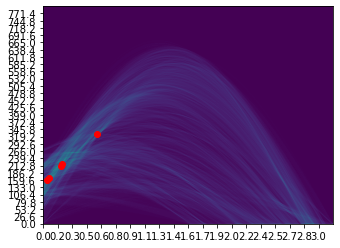

In [41]:
plt.imshow(myHoughimg, origin='lower')
tick_locs = [i for i in range(0,theta_dim,40)]
tick_lbls = [round( (1.0 * i * theta_max) / theta_dim,1) for i in range(0,theta_dim,40)]
plt.xticks(tick_locs, tick_lbls)

tick_locs = [i for i in range(0,r_dim,20)]
tick_lbls = [round( (1.0 * i * r_max ) / r_dim,1) for i in range(0,r_dim,20)]
plt.yticks(tick_locs, tick_lbls)

plt.autoscale(False)
plt.plot(x,y, 'ro')

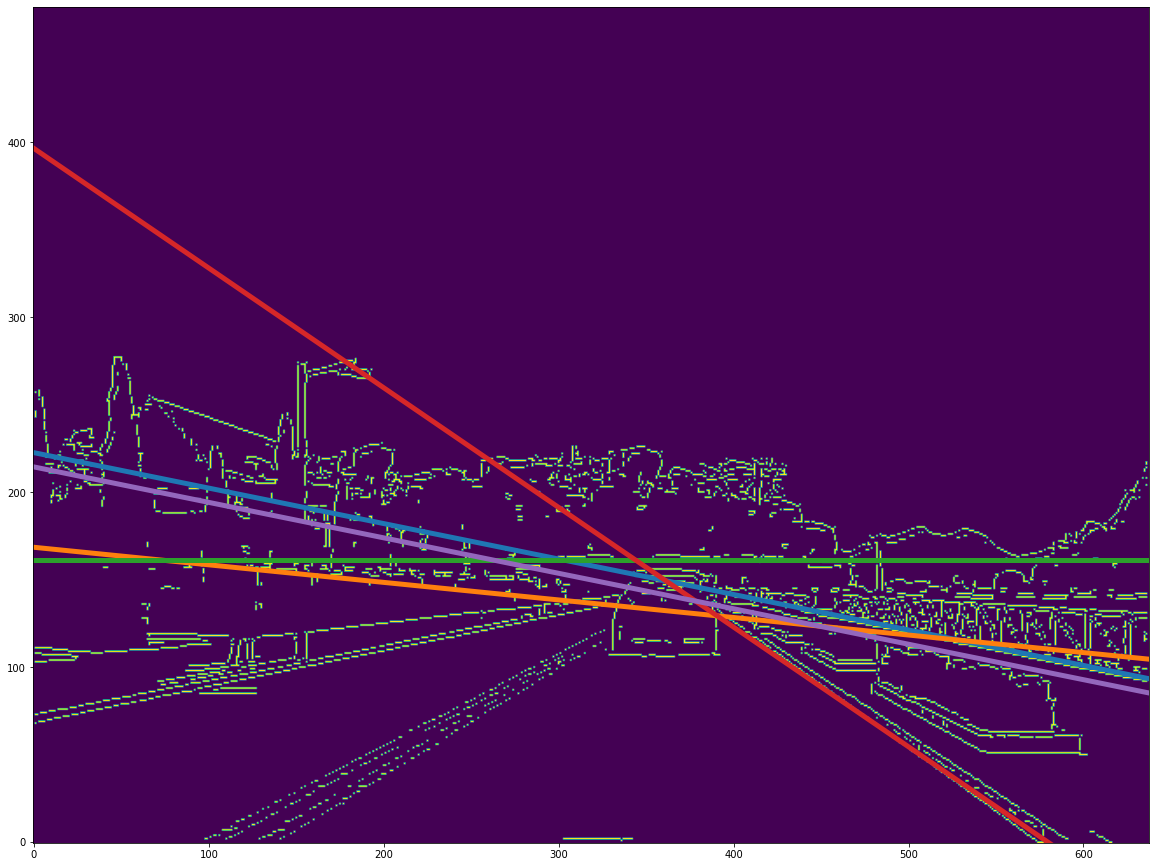

In [42]:
# Step 4: Plot lines

line_index = 1
width, height = myhysteresis.shape
r_max = np.ceil(np.sqrt(width * width + height * height))   
theta_max = np.pi
r_dim, theta_dim = myHoughimg.shape

x_max = width
y_max = height

f, axarr = plt.subplots(1,1, figsize=(20, 20))
axarr.imshow(myhysteresis, origin='lower')


for i,j in zip(y, x):

    r = round( (1.0 * i * r_max ) / r_dim,1)
    theta = round( (1.0 * j * theta_max) / theta_dim,1)

    

    axarr.autoscale(False)

    px = []
    py = []
    for i in range(-y_max-40,y_max+40,1):
        px.append( math.cos(-theta) * i - math.sin(-theta) * r ) 
        py.append( math.sin(-theta) * i + math.cos(-theta) * r )

    axarr.plot(px,py, linewidth=5)